# Unconstrained Optimization - Part II

[Steepest Descent](#Steepest_Descent) <br />
[Newton Optimization](#Newton_Optimization) <br />
[Example 1](#Example1)  
[Example 2](#Example2)  


# Introduction

To solve these minimization problems, we have to search for the stationary points - this notebook considers first and second order methods that just use the gradient of the function to do this search.

# Solution Methods
Typically solve minimization problem using an iterative
algorithm. 

1. Given: An initial estimate of the optimizing value of
$\mathbf{x}$ to $\mathbf{\hat x}_k$ and a search direction $\mathbf{p}_k$

2. Find: $\mathbf{\hat x}_{k+1}=\mathbf{\hat x}_k + \alpha_k \mathbf{p}_k$, for
some scalar $\alpha_k \neq 0$

Sounds good, but there are some questions:
1. How find $\mathbf{p}_k$? -- use negative of the function gradient 
2. How find $\alpha_k$ ? -- a **line search**
3. How find initial condition $\mathbf{x}_0$, and how sensitive is the
answer to the choice?

Resulting approach is called **steepest descent**

In [1]:
from os.path import exists
file_exists = exists('basic_material.py')

if (not file_exists):
    !wget -O basic_material.py https://www.dropbox.com/s/3aoexl8vxyitmds/basic_material.py?dl=0
%run basic_material

try:
    %reload_ext autoreload
except:
    %load_ext autoreload
%autoreload 2

plt.rcParams['axes.grid'] = False

import pandas as pd

if os.path.isdir("./figs/"):
    pass
else:
    !mkdir ./figs

Running Python: 3.9.9


First define some interesting examples to consider

<a id='Example1'></a>
## Example 1

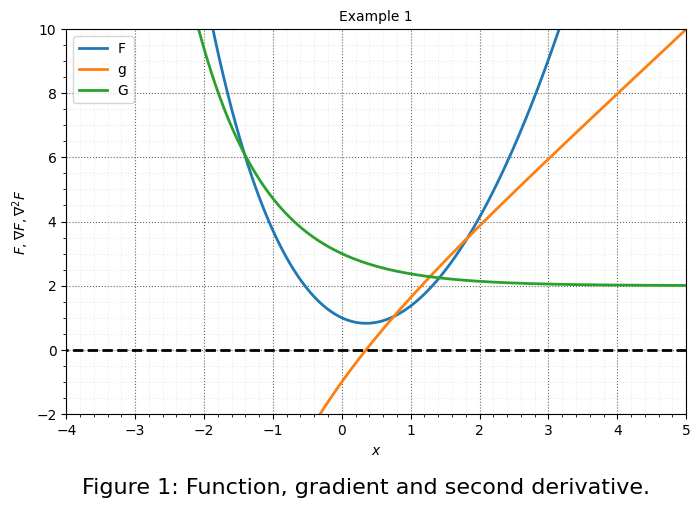

Expect the minimum to be at 0.352


In [2]:
#define symbolic vars, function
sx = sym.symbols('sx')
ex1_fun = sym.exp(-sx)+sx**2
ex1_numfun = sym.lambdify([sx],ex1_fun) # ftn
ex1_gradfun = sym.diff(ex1_fun,sx) #take the gradient symbolically wrt x
ex1_numgradfun = sym.lambdify([sx],ex1_gradfun) #turn into a bivariate lambda for numpy
ex1_hessfun = sym.diff(ex1_gradfun,sx) #take the Hessian symbolically wrt x
ex1_numhessfun = sym.lambdify([sx],ex1_hessfun) #turn into a bivariate lambda for numpy

X = np.arange(-5, 5, 0.01)
F = ex1_numfun(X)
g = ex1_numgradfun(X)
G = ex1_numhessfun(X)

fig = plt.figure(1,figsize=(8,5))
ax = fig.add_subplot()
ax.plot(X,F,label='F')
ax.plot(X,g,label='g')
ax.plot(X,G,label='G')
ax.plot(X,0*X,'k--')

ax.set_ylim([-2, 10])
ax.set_xlim([-4, 5])
nicegrid()

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$F, \nabla F, \nabla^2 F$')
ax.set_title('Example 1')
ax.legend(loc='best')

fig.savefig("figs/L1_ex1.png")
txt="Figure 1: Function, gradient and second derivative."
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=16)
plt.show()

root_ex1, info, ier, mesg = optimize.fsolve(ex1_numgradfun, [0], xtol=1e-11,full_output=True)
print('Expect the minimum to be at '+str(round(root_ex1[0],3)))

Plot shows one minimum (where $g = 0$) and note that $G > 0$ for all values of $x$, so would expect that to be a minimum.

<a id='Example2'></a>
## Example 2

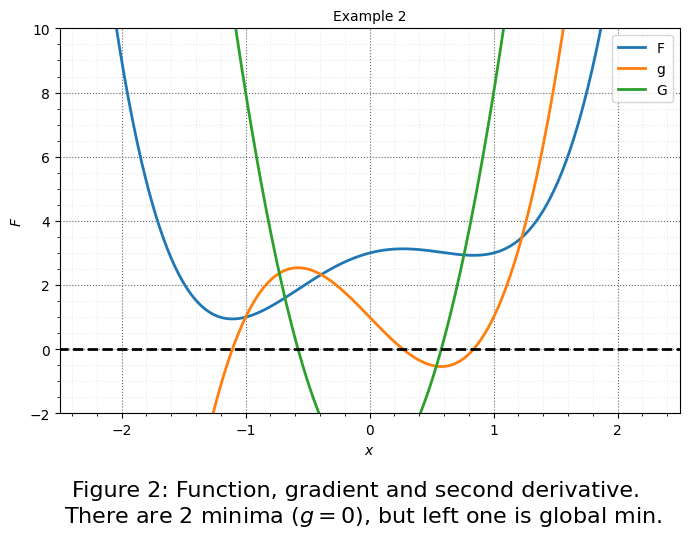

In [3]:
# Example 2
ex2_fun = sx**4-2*sx**2+sx+3
ex2_numfun = sym.lambdify([sx],ex2_fun) # ftn
ex2_gradfun = sym.diff(ex2_fun,sx) #take the gradient symbolically wrt x
ex2_numgradfun = sym.lambdify([sx],ex2_gradfun) #turn into a bivariate lambda for numpy
ex2_hessfun = sym.diff(ex2_gradfun,sx) #take the Hessian symbolically wrt x
ex2_numhessfun = sym.lambdify([sx],ex2_hessfun) #turn into a bivariate lambda for numpy

X2 = np.arange(-3, 3, 0.01)
F2 = ex2_numfun(X2)
g2 = ex2_numgradfun(X2)
G2 = ex2_numhessfun(X2)

fig = plt.figure(2,figsize=(8,5))
ax = fig.add_subplot()
ax.plot(X2,F2,label='F')
ax.plot(X2,g2,label='g')
ax.plot(X2,G2,label='G')
ax.plot(X2,0*X2,'k--')
ax.legend()
ax.set_ylim([-2, 10])
ax.set_xlim([-2.5, 2.5])
nicegrid()

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$F$')
ax.set_title('Example 2')

fig.savefig("figs/L1_ex2.png")
txt="Figure 2: Function, gradient and second derivative. \n There are 2 minima ($g = 0$), but left one is global min."
plt.figtext(0.5, -0.1, txt, wrap=True, horizontalalignment='center', fontsize=16)
plt.show()

Function shows various minima and local maxima - correspondingly we can see 3 values 
of $x$ for which the gradient $g$ is zero, which different signs for the Hessian $G$ 

We will first find them by a brute force methods and then develop methods to search for these extrema points.

In [4]:
root_ex2=np.zeros(3)
root_ex2[0], info, ier, mesg = optimize.fsolve(ex2_numgradfun, [-1], xtol=1e-11,full_output=True)
root_ex2[1], info, ier, mesg = optimize.fsolve(ex2_numgradfun, [0], xtol=1e-11,full_output=True)
root_ex2[2], info, ier, mesg = optimize.fsolve(ex2_numgradfun, [1], xtol=1e-11,full_output=True)
print('Expect the stationary points to be at ',root_ex2)

Expect the stationary points to be at  [-1.1072  0.2696  0.8376]


<a id='Steepest_Descent'></a>
## First-order Methods: Steepest Descent
Taylor series expansion of $F(\mathbf{x})$ about the current
estimate $\mathbf{\hat x}_k \to \mathbf{\hat x}_{k+1} = \mathbf{\hat x}_k + \alpha_k \mathbf{p}_k$ 
\begin{align}
F_{k+1}\equiv F(\mathbf{\hat x}_k + \alpha_k \mathbf{p}_k) 
&\approx F(\mathbf{\hat x}_k) + \left. \frac{\partial F}{\partial \mathbf{x}} \right|_{\mathbf{\hat x}_{k}} (\mathbf{\hat x}_{k+1}-\mathbf{\hat x}_k) \\
&= F_k + \mathbf{g}_k^T (\alpha_k \mathbf{p}_k)
\end{align}

Assume that $\alpha_k > 0$, and to ensure function decreases   (i.e. $F_{k+1} < F_k$), so we must set $$ \mathbf{g}_k^T \mathbf{p}_k < 0$$

The $\mathbf{p}_k$'s that satisfy this property provide a **descent
direction**. The **Steepest descent** is given by $\mathbf{p}_k=-\mathbf{g}_k$
so we should execute: $$
\mathbf{\hat x}_{k+1} = \mathbf{\hat x}_k - \alpha_k \mathbf{g}_k
$$

Given this, there are a lot of heuristics and rules of thumb on how to pick $\alpha$, such as polynomial approximations, Golden section search, bisection etc. It is accomplished here by the function *line_search*.

<a id='Newton_Optimization'></a>
## Second-order Methods: Newton Optimization

Here we step in the direction of $\mathbf{p}_k$ to ensure that $\mathbf{g}_{k+1}=0$, which given that
$$
\mathbf{g}_{k+1} = \mathbf{g}_k + G_k \mathbf{p}_k
$$
requires that 
$$
\mathbf{p}_k = -G_k^{-1} \mathbf{g}_k
$$
there is no line search in this case - we just take $\alpha = 1$.

## Algorithms
The following implements these 2 approaches in search algorithms

In [5]:
# Steepest Descent
def Steepest_Descent(x0,var):
    fx = var+'numfun(start_point)' # example gradient
    fgx = var+'numgradfun(start_point)' # example hessian
    f = var+'numfun' # example gradient
    fg = var+'numgradfun' # example hessian

    Niter = 200 # arbitrary (could use smarter temination criteria)
    start_point = x0
    X = np.array([start_point,eval(fx)])
    for k in range(1,Niter):
        search_gradient = eval(fgx)
        sol = line_search(eval(f), eval(fg), start_point, -search_gradient)
        if sol[0] == None:
            return X
        else:
            start_point = start_point - sol[0]*search_gradient
            X = np.append(X,np.array([start_point, eval(fx)]))
    return X

# Newton Optimization Solution Method
def NO_Alg(x0,var):
    fg = var+'numgradfun(x)' # example gradient
    fG = var+'numhessfun(x)' # example hessian
    newx = x0
    dx = 1 # change in x in a step
    Tol = 1e-5
    X = np.array(x0)
    while (dx > Tol):
        x = newx
        G = eval(fG)
        if (abs(G) > 0):
            newx = x - eval(fg)/G
        else:
            newx = x - eval(fg) # avoids  the inverse of 0
        dx = np.abs(newx - x)  # how far stepped  
        X = np.append(X,newx)  # store solution path       
    return X


## Analyze impact of different Initial Conditions on the optimized answers

In [6]:
# Try example 1 at 2 starting points
X11 = NO_Alg(4,'ex1_')
X111 = Steepest_Descent(4,'ex1_')

X12 = NO_Alg(-2,'ex1_')
X121 = Steepest_Descent(-2,'ex1_')

/Users/jonathanhow/myenv/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


In [7]:
table = []
table.append(X11)
table.append(X111[0:-1:2])
table.append(X12)
table.append(X121[0:-1:2])
df = pd.DataFrame(table, index=['NO', 'SD','NO', 'SD'])
df[df.isna()]=0
print(df.T)

         NO        SD        NO        SD
0  4.000000  4.000000 -2.000000 -2.000000
1  0.045374  1.829743 -0.786986  1.577368
2  0.337998  0.557012  0.111501  0.492933
3  0.351709  0.355999  0.343489  0.353770
4  0.351734  0.351736  0.351725  0.351734
5  0.351734  0.351734  0.351734  0.351734


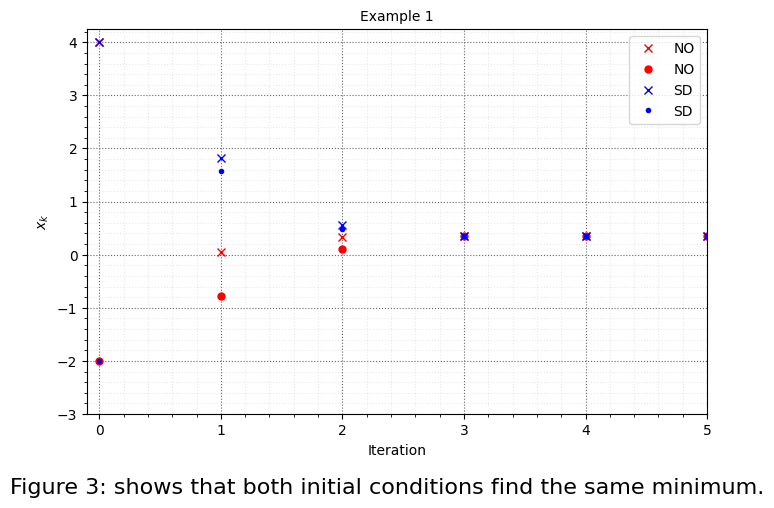

In [8]:
# Plot example 1
fig = plt.figure(3,figsize=(8,5))
ax = fig.add_subplot()
ax.set_ylim([-3, 4.25])
ax.set_xlim([-.1, 5])
ax.grid(axis='both')

ax.set_xlabel(r'Iteration')
ax.set_ylabel(r'$x_k$')
ax.set_title('Example 1')

ax.plot(X11, 'rx',label='NO')
ax.plot(X12, 'r.',ms=10,label='NO')
ax.plot(X111[0:-1:2], 'bx',label='SD')
ax.plot(X121[0:-1:2], 'b.',label='SD')
nicegrid()
ax.legend()

fig.savefig("figs/L1_ex11.png")
txt="Figure 3: shows that both initial conditions find the same minimum."
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=16)
plt.show()

In [9]:
print('Repeat for second example') 
X21 = NO_Alg(10,'ex2_')
X211 = Steepest_Descent(10,'ex2_')
X22 = NO_Alg(-2,'ex2_')
X221 = Steepest_Descent(-2,'ex2_')

Repeat for second example


/Users/jonathanhow/myenv/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


In [10]:
table = []
table.append(X21)
table.append(X211[0:-1:2])
table.append(X22)
table.append(X221[0:-1:2])
df = pd.DataFrame(table, index=['NO', 'SD','NO', 'SD'])
df[df.isna()]=0
print(df.T)
print('\nClear that these initial conditions find different answers\n\n') 

           NO         SD        NO        SD
0   10.000000  10.000000 -2.000000 -2.000000
1    6.688127  -5.172818 -1.477273  1.586678
2    4.490350   3.819317 -1.207464 -1.545508
3    3.039685  -3.462720 -1.117663 -0.436929
4    2.092943   2.212863 -1.107294 -1.123252
5    1.489627  -0.869490 -1.107160 -1.104982
6    1.124442  -1.142421 -1.107160 -1.107145
7    0.928507  -1.095301  0.000000 -1.107160
8    0.851613  -1.106727  0.000000  0.000000
9    0.837992  -1.107159  0.000000  0.000000
10   0.837566  -1.107160  0.000000  0.000000
11   0.837565   0.000000  0.000000  0.000000

Clear that these initial conditions find different answers




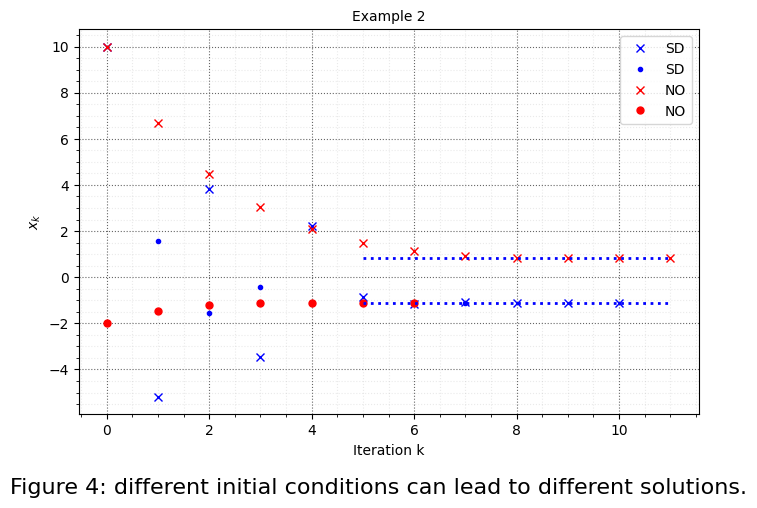

In [11]:
fig = plt.figure(5,figsize=(8,5))
plt.plot(X211[0:-1:2], 'bx',label='SD')
plt.plot(X221[0:-1:2], 'b.',label='SD')
plt.plot(X21, 'rx',label='NO')
plt.plot(X22, 'r.',ms=10,label='NO')
plt.plot([5, 11],[root_ex2[0],root_ex2[0]], 'b:')
plt.plot([5, 11],[root_ex2[2],root_ex2[2]], 'b:')

plt.grid()
plt.legend()
plt.xlabel(r'Iteration k')
plt.ylabel(r'$x_k$')
plt.title('Example 2')
nicegrid()

plt.savefig("figs/L1_ex21.png")
txt="Figure 4: different initial conditions can lead to different solutions."
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=16)
plt.show()